In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv("loan-recovery.csv")
print(df.head())

  Borrower_ID  Age  Gender Employment_Type  Monthly_Income  Num_Dependents  \
0       BRW_1   59    Male        Salaried          215422               0   
1       BRW_2   49  Female        Salaried           60893               0   
2       BRW_3   35    Male        Salaried          116520               1   
3       BRW_4   63  Female        Salaried          140818               2   
4       BRW_5   28    Male        Salaried           76272               1   

  Loan_ID  Loan_Amount  Loan_Tenure  Interest_Rate  ... Collateral_Value  \
0    LN_1      1445796           60          12.39  ...     1.727997e+06   
1    LN_2      1044620           12          13.47  ...     1.180032e+06   
2    LN_3      1923410           72           7.74  ...     2.622540e+06   
3    LN_4      1811663           36          12.23  ...     1.145493e+06   
4    LN_5        88578           48          16.13  ...     0.000000e+00   

   Outstanding_Loan_Amount  Monthly_EMI  Payment_History Num_Missed_Paymen

Now, let’s have a look at the summary statistics of the data before moving forward:

In [2]:
df.describe()

Age  Monthly_Income  Num_Dependents   Loan_Amount  Loan_Tenure  \
count  500.000000      500.000000      500.000000  5.000000e+02    500.00000   
mean    43.116000   134829.920000        1.476000  1.024907e+06     46.10400   
std     12.733217    68969.356746        1.145447  5.907556e+05     18.23706   
min     21.000000    15207.000000        0.000000  5.413800e+04     12.00000   
25%     32.000000    76343.250000        0.000000  4.629848e+05     36.00000   
50%     44.000000   134929.500000        1.000000  9.971240e+05     48.00000   
75%     53.000000   193086.250000        3.000000  1.557952e+06     60.00000   
max     64.000000   249746.000000        3.000000  1.995325e+06     72.00000   

       Interest_Rate  Collateral_Value  Outstanding_Loan_Amount  \
count     500.000000      5.000000e+02             5.000000e+02   
mean       11.192820      6.032240e+05             5.627260e+05   
std         3.775209      7.457131e+05             4.723581e+05   
min         5.020000      0.000000e+00             1.571283e+04   
25%         7.907500      0.000000e+00             1.822072e+05   
50%        10.915000      2.327684e+05             4.133240e+05   
75%        14.577500      1.111106e+06             8.324787e+05   
max        17.970000      2.744395e+06             1.932396e+06   

         Monthly_EMI  Num_Missed_Payments  Days_Past_Due  Collection_Attempts  
count     500.000000           500.000000     500.000000           500.000000  
mean    15861.536020             1.912000      70.678000             3.000000  
std     18709.231315             2.110252      60.211038             2.807805  
min       261.880000             0.000000       0.000000             0.000000  
25%      4039.097500             1.000000       4.000000             1.000000  
50%      9330.170000             2.000000      66.500000             2.000000  
75%     20439.485000             3.000000     122.250000             4.000000  
max    127849.230000            12.000000     180.000000            10.000000

#### Analyzing Data Distribution and Relationships
Now, let’s move to analyzing this data in detail. I’ll first have a look at the distribution of the loan amount and its relationship with the monthly income:

In [3]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd


fig = px.histogram(df, x='Loan_Amount', nbins=30, marginal="violin", opacity=0.7,
                   title="Loan Amount Distribution & Relationship with Monthly Income",
                   labels={'Loan_Amount': "Loan Amount (in $)", 'Monthly_Income': "Monthly Income"},
                   color_discrete_sequence=["royalblue"])

fig.add_trace(go.Scatter(
    x=sorted(df['Loan_Amount']),
    y=px.histogram(df, x='Loan_Amount', nbins=30, histnorm='probability density').data[0]['y'],
    mode='lines',
    name='Density Curve',
    line=dict(color='red', width=2)
))

scatter = px.scatter(df, x='Loan_Amount', y='Monthly_Income',
                     color='Loan_Amount', color_continuous_scale='Viridis',
                     size=df['Loan_Amount'], hover_name=df.index)

for trace in scatter.data:
    fig.add_trace(trace)

fig.update_layout(
    annotations=[
        dict(
            x=max(df['Loan_Amount']) * 0.8, y=max(df['Monthly_Income']),
            text="Higher Loan Amounts are linked to Higher Income Levels",
            showarrow=True,
            arrowhead=2,
            font=dict(size=12, color="red")
        )
    ],
    xaxis_title="Loan Amount (in $)",
    yaxis_title="Monthly Income (in $)",
    template="plotly_white",
    showlegend=True
)

fig.show()

The graph demonstrates a positive relationship between loan amounts and monthly income, indicating that individuals with higher income levels tend to secure larger loans. The density curve at the top shows the distribution of loan amounts, emphasizing that higher loan amounts are more frequent among higher income brackets.

It highlights the proportionality between income and loan size, which shows an income-based approach in loan approvals or customer profiling.

#### Analyzing Payment History
Now, let’s have a look at the payment history. I’ll first analyze how payment history affects loan recovery amount:

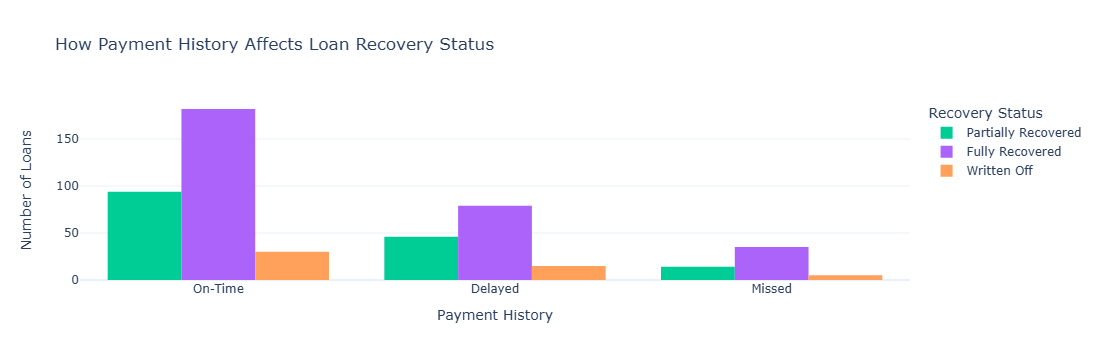

In [4]:
fig = px.histogram(df, x="Payment_History", color="Recovery_Status", barmode="group",
                   title="How Payment History Affects Loan Recovery Status",
                   labels={"Payment_History": "Payment History", "count": "Number of Loans"},
                   color_discrete_map={"Recovered": "green", "Not Recovered": "red"})

fig.update_layout(
    xaxis_title="Payment History",
    yaxis_title="Number of Loans",
    legend_title="Recovery Status",
    template="plotly_white",
        )

fig.show()

Loans with on-time payments are mostly fully recovered. Delayed payments result in a mix of partial and full recoveries, with some written off. Missed payments have a significantly lower recovery rate, with most loans ending up either partially recovered or written off.

Let’s dive into missed payments in detail by analyzing how missed payments affect loan recovery:

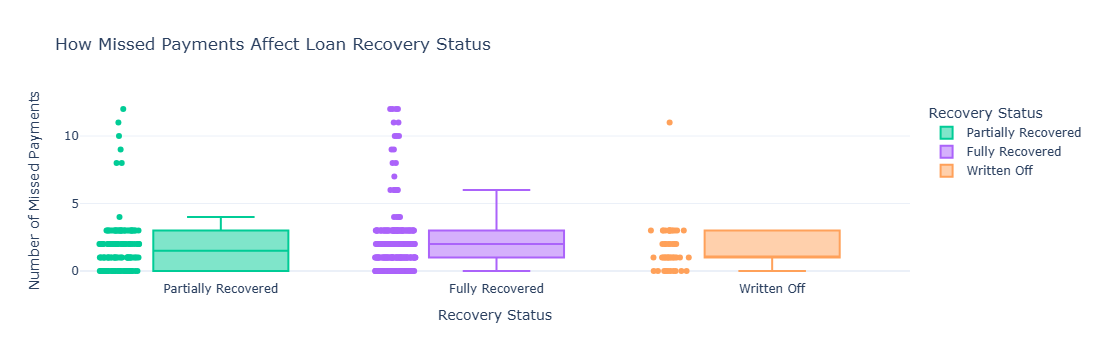

In [5]:
fig = px.box(df, x="Recovery_Status", y="Num_Missed_Payments",
             title="How Missed Payments Affect Loan Recovery Status",
             labels={"Recovery_Status": "Recovery Status", "Num_Missed_Payments": "Number of Missed Payments"},
             color="Recovery_Status",
             color_discrete_map={"Recovered": "green", "Not Recovered": "red"},
             points="all")

fig.update_layout(
    xaxis_title="Recovery Status",
    yaxis_title="Number of Missed Payments",
    template="plotly_white"
)

fig.show()

Loans with partial recovery typically have up to 4 missed payments. Fully recovered loans tend to have fewer missed payments, mostly between 0 and 2. Written-off loans show a higher range of missed payments, with several exceeding 6. A higher number of missed payments significantly reduces the likelihood of full recovery and increases the chances of loans being written off.

#### Analyzing Loan Recovery Based on Monthly Income
Now, let’s dive deep into the relationship between monthly income and loan amount recovery. I’ll first analyze how monthly income and loan amount affect the loan recovery:

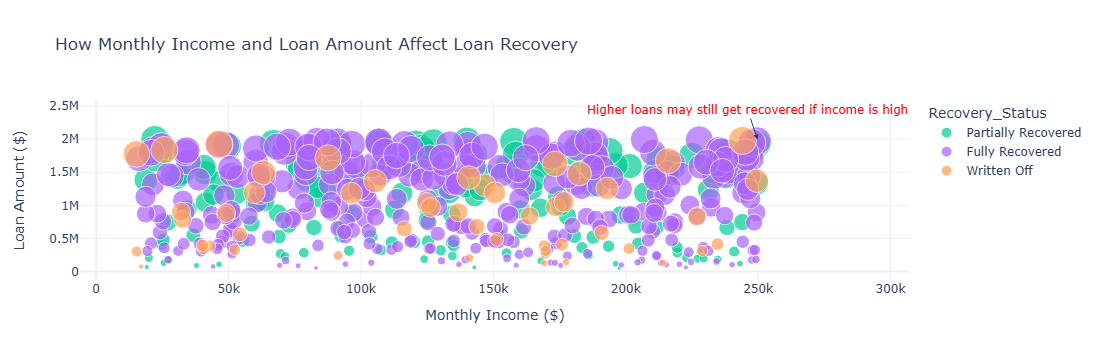

In [6]:
fig = px.scatter(df, x='Monthly_Income', y='Loan_Amount',
                 color='Recovery_Status', size='Loan_Amount',
                 hover_data={'Monthly_Income': True, 'Loan_Amount': True, 'Recovery_Status': True},
                 title="How Monthly Income and Loan Amount Affect Loan Recovery",
                 labels={"Monthly_Income": "Monthly Income ($)", "Loan_Amount": "Loan Amount ($)"},
                 color_discrete_map={"Recovered": "green", "Not Recovered": "red"})

fig.add_annotation(
    x=max(df['Monthly_Income']), y=max(df['Loan_Amount']),
    text="Higher loans may still get recovered if income is high",
    showarrow=True,
    arrowhead=2,
    font=dict(size=12, color="red")
)

fig.update_layout(
    xaxis_title="Monthly Income ($)",
    yaxis_title="Loan Amount ($)",
    template="plotly_white"
)

fig.show()

Higher-income individuals are more likely to fully recover their loans, even for larger amounts. Borrowers in lower income brackets face a higher likelihood of loan write-offs or partial recovery. This trend highlights the impact of income on loan recovery, as higher earnings lead to better repayment outcomes and fewer write-offs, even for substantial loans.

Now, using K-Means clustering, I’ll create borrower segments based on monthly income and loan amount:

In [7]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = ['Age', 'Monthly_Income', 'Loan_Amount', 'Loan_Tenure', 'Interest_Rate',
            'Collateral_Value', 'Outstanding_Loan_Amount', 'Monthly_EMI', 'Num_Missed_Payments', 'Days_Past_Due']

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

Let’s visualize the segments to understand them in detail:

In [8]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Borrower_Segment'] = kmeans.fit_predict(df_scaled)

fig = px.scatter(df, x='Monthly_Income', y='Loan_Amount',
                 color=df['Borrower_Segment'].astype(str), size='Loan_Amount',
                 hover_data={'Monthly_Income': True, 'Loan_Amount': True, 'Borrower_Segment': True},
                 title="Borrower Segments Based on Monthly Income and Loan Amount",
                 labels={"Monthly_Income": "Monthly Income ($)", "Loan_Amount": "Loan Amount ($)", "Borrower_Segment": "Segment"},
                 color_discrete_sequence=px.colors.qualitative.Vivid)

fig.add_annotation(
    x=df['Monthly_Income'].mean(), y=df['Loan_Amount'].max(),
    text="Higher loans are clustered in specific income groups",
    showarrow=True,
    arrowhead=2,
    font=dict(size=12, color="red")
)

fig.update_layout(
    xaxis_title="Monthly Income ($)",
    yaxis_title="Loan Amount ($)",
    template="plotly_white",
    legend_title="Borrower Segment"
)

fig.show()

Segment 1 borrowers take on moderate to high loan amounts, indicating financial stability. The Segment 0 clusters around lower income levels and moderate loan sizes, reflecting potential financial strain. Segment 2 borrowers distribute evenly across the graph, representing a balanced but cautious group. Meanwhile, Segment 3 borrowers concentrate in high-loan areas, especially within specific high-income ranges, highlighting their susceptibility to default despite higher incomes.

Let’s name these segments according to the clusters they represent:

In [9]:
# updating segment names
df['Segment_Name'] = df['Borrower_Segment'].map({
    0: 'Moderate Income, High Loan Burden',
    1: 'High Income, Low Default Risk',
    2: 'Moderate Income, Medium Risk',
    3: 'High Loan, Higher Default Risk'
})

### Building an Early Detection System for Loan Defaults based on the Risk Scores
Now, we will use our segments to build a classification model to flag the borrowers with high default risk. Once the model finds the borrowers with a high default risk, we will assign a loan recovery strategy based on the level of the risk of the borrower. Let’s train the model first:

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df['High_Risk_Flag'] = df['Segment_Name'].apply(lambda x: 1 if x in ['High Loan, Higher Default Risk', 'Moderate Income, High Loan Burden'] else 0)

# selecting features for the model
features = ['Age', 'Monthly_Income', 'Loan_Amount', 'Loan_Tenure', 'Interest_Rate',
            'Collateral_Value', 'Outstanding_Loan_Amount', 'Monthly_EMI', 'Num_Missed_Payments', 'Days_Past_Due']
X = df[features]
y = df['High_Risk_Flag']

# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# training the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# get risk scores (probability of being high risk)
risk_scores = rf_model.predict_proba(X_test)[:, 1]  # probability of high risk

# add risk scores and flags to test data
df_test = X_test.copy()
df_test['Risk_Score'] = risk_scores
df_test['Predicted_High_Risk'] = (df_test['Risk_Score'] > 0.5).astype(int)  # Threshold at 50% probability

# merging with borrower details
df_test = df_test.merge(df[['Borrower_ID', 'Segment_Name', 'Recovery_Status', 'Collection_Method', 'Collection_Attempts', 'Legal_Action_Taken']],
                        left_index=True, right_index=True)

Here, we first labelled borrowers as high-risk based on their segment classification. Then, we selected key financial and behavioural features to train a Random Forest Classifier. After splitting the data into training and testing sets, we trained the model to predict the probability of a borrower defaulting. We then applied this model to the test data to generate risk scores and classify borrowers as high-risk or low-risk based on a probability threshold. Finally, we merged these predictions with borrower details to enable data-driven recovery strategies.

Now, we will create a new column for the dynamic recovery strategy based on risk scores:

In [11]:
# creating a new column for the dynamic recovery strategy based on risk scores
def assign_recovery_strategy(risk_score):
    if risk_score > 0.75:
        return "Immediate legal notices & aggressive recovery attempts"
    elif 0.50 <= risk_score <= 0.75:
        return "Settlement offers & repayment plans"
    else:
        return "Automated reminders & monitoring"

df_test['Recovery_Strategy'] = df_test['Risk_Score'].apply(assign_recovery_strategy)

df_test.head()

Age  Monthly_Income  Loan_Amount  Loan_Tenure  Interest_Rate  \
342   60           55390       467567           72          15.28   
427   23          247041      1106600           48          15.48   
320   48          177982       838245           72           7.71   
217   26          157628       446981           60           5.10   
67    54          232285       970114           48          14.32   

     Collateral_Value  Outstanding_Loan_Amount  Monthly_EMI  \
342      0.000000e+00            303243.056846      4211.71   
427      1.538436e+06            189941.880380      3957.12   
320      1.110513e+06            428391.422250      5949.88   
217      2.765295e+05            247997.900946      4133.30   
67       0.000000e+00            814388.790842     16966.43   

     Num_Missed_Payments  Days_Past_Due  Risk_Score  Predicted_High_Risk  \
342                    0              0        0.04                    0   
427                    3            152        0.47                    0   
320                    0              0        0.02                    0   
217                    3             61        0.21                    0   
67                     2            166        0.76                    1   

    Borrower_ID                    Segment_Name      Recovery_Status  \
342     BRW_343    Moderate Income, Medium Risk  Partially Recovered   
427     BRW_428  High Loan, Higher Default Risk      Fully Recovered   
320     BRW_321    Moderate Income, Medium Risk  Partially Recovered   
217     BRW_218    Moderate Income, Medium Risk      Fully Recovered   
67       BRW_68  High Loan, Higher Default Risk      Fully Recovered   

    Collection_Method  Collection_Attempts Legal_Action_Taken  \
342   Debt Collectors                    5                 No   
427   Debt Collectors                    3                 No   
320      Legal Notice                    1                 No   
217             Calls                    3                 No   
67   Settlement Offer                    3                 No   

                                     Recovery_Strategy  
342                   Automated reminders & monitoring  
427                   Automated reminders & monitoring  
320                   Automated reminders & monitoring  
217                   Automated reminders & monitoring  
67   Immediate legal notices & aggressive recovery ...

Here, we defined a function that categorizes borrowers into three recovery approaches:orts.

1. immediate legal action for high-risk borrowers (risk score > 0.75)

2. settlement offers and repayment plans for moderate-risk borrowers (0.50 – 0.75)

3. automated reminders for low-risk borrowers (<0.50)

This function was applied to the test dataset to assign a personalized recovery strategy to each borrower to ensure cost-effective and targeted loan recovery efforts.